In [1]:
import torch
import numpy as np

In [2]:
from matplotlib import pyplot as plt

In [23]:
import numpy as np
from scipy.stats import zscore
from miscellaneous.augumentation import TimeAugumentation, FreqencyAugumentation

TIME_AUG = TimeAugumentation(256,mask_rate=0.4, sigma=0.1)
FREQ_AUG = FreqencyAugumentation(256,8,0.1,0.4)

def normalize(x:dict):
    x['EEG_Raw'] = zscore(x['EEG_Raw'], axis=-1).astype(np.float32)
    return x

def scale(x:dict):
    x['EEG_Raw'] = x['EEG_Raw'] * 1e5
    return x

def FFT(x:dict):
    x['Freq'] = np.log(abs(np.fft.rfft(x['EEG_Raw'], axis=-1)) + 1e-6).astype(np.float32)
    return x

def augument(x:dict):
    x['EEG_Raw_Aug'] = TIME_AUG(x['EEG_Raw'], bandstop=False).astype(np.float32)
    x['Freq_Aug'] = FREQ_AUG(x['Freq'], perturbation=False).astype(np.float32)
    return x

def crop(x:dict, windows=256*4):
    start = np.random.randint(0, x['EEG_Raw'].shape[1] - windows)
    end = start + windows
    x['EEG_Raw'] = x['EEG_Raw'][..., start:end]
    return x
 
def sample_channel(x:dict):
    x['EEG_Raw'] = x['EEG_Raw'][11:12]
    return x

def toFloat(x:dict):
    for k in x.keys():
        if isinstance(x[k], torch.Tensor):
            x[k] = x[k].float()
        elif isinstance(x[k], np.ndarray):
            x[k] = x[k].astype(np.float32)
    return x

class Composer(object):
    def __init__(self, *funcs):
        self.funcs = funcs

    def __call__(self, x:dict):
        for f in self.funcs:
            x = f(x)
        return x


In [24]:
from miscellaneous.dataloader import FHA_Unsupervised
NBatch = 128
preprocess = Composer(normalize, FFT, augument)
dataset_config={'channels': 1, 'window_size':256*8, 'sampling_rate':256, 'access_pattern':'random', 'label':['ComorbidityLevelDesc', 'Age'], 'preprocess':preprocess}
dataset = FHA_Unsupervised(r"D:\EEG\FHA\Resting\001_a01_01\Annotations\Surrey_Chunks.csv", r"D:\EEG\FHA\Resting\chunks", dataset_config)

from torch.utils.data import DataLoader
dataloader_train = DataLoader(dataset, batch_size=NBatch, shuffle=False, num_workers=0,drop_last=True)

In [25]:
from miscellaneous.dataloader import FHA_Supervised
from functools import partial
preprocess = Composer(normalize,partial(crop, windows=256*8), sample_channel, )
dataset_eval = FHA_Supervised(r"D:\EEG\FHA\Resting\001_a01_01", r"Annotations\Burnaby_Chunks.csv", r".hdf5",fileType='hd5', dataset_path=r"clips", keys=['EEG_Raw'], labels=['ComorbidityLevelDesc', 'Age'], preprocessor = preprocess,validation=False,filter=' Age > 18')

dataloader_eval = DataLoader(dataset_eval, batch_size=64, shuffle=False, num_workers=0)

In [26]:
from miscellaneous.loss import NTXentLoss_poly
from trainer import TFC_trainer_on_epoch
    
def train(model, train_dataloader, eval_dataloader, optimizer, device,batch_size=32, epochs=100,save_dir='result', writer=None):
    #trainin rate scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, last_epoch=-1)
    loss_fn = NTXentLoss_poly(device,batch_size, 0.2, True)
    best_accuracy = 0
    
    for epoch in range(epochs):
        loss = TFC_trainer_on_epoch(model, train_dataloader, batch_size, optimizer, loss_fn, device)
        scheduler.step()
        print(f'Epoch {epoch} Loss {loss}')
        
        r2, accuracy = validation_task(model, eval_dataloader, device)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            torch.save(model.state_dict(), save_dir + 'best_model.pth')
        if writer is not None:
            writer.add_scalar('R2', r2, epoch)
            writer.add_scalar('Accuracy', accuracy, epoch)
            writer.add_scalar('Loss', loss, epoch)
    model.load_state_dict(torch.load(save_dir + 'best_model.pth'))
    writer.close()

@torch.no_grad()
def validation(model, dataloader_eval, device):
    model.eval()
    model.to(device)
    representation = []
    age = []
    comorbidity = []
    for i, batch in enumerate(dataloader_eval):
        data_t = batch['EEG_Raw'].to(device)
        _comorbidity = batch['ComorbidityLevelDesc']
        _age = batch['Age']
        
        h_t = model.encoder_t(data_t)
        representation.append(h_t.mean(dim=1).detach().cpu().numpy())
        age.append(_age.detach().cpu().numpy())
        comorbidity.append(_comorbidity.detach().cpu().numpy())

    representation = np.concatenate(representation, axis=0)
    comorbidity = np.concatenate(comorbidity, axis=0)
    age = np.concatenate(age, axis=0)
    return representation, comorbidity, age


def age_regression(features, targets):
    from sklearn.linear_model import Lasso
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=42)
    model = make_pipeline(StandardScaler(), Lasso())
    model.fit(X_train, y_train)

    # Calculate the R^2 score
    r2 = model.score(X_test, y_test)
    print(f'R^2 Score: {r2}')

    return r2

def abnormality_detection(features, targets):
    from sklearn.linear_model import LogisticRegression
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.3, random_state=42)
    model = make_pipeline(StandardScaler(), LogisticRegression())
    model.fit(X_train, y_train)

    # Calculate the ROC AUC score
    from sklearn.metrics import roc_auc_score
    y_pred = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, y_pred)
    print(f'AUC Score: {score}')

    return score

def validation_task(model, dataloader_eval, device):
    features, comorbidity, age = validation(model, dataloader_eval, device)
    # Perform age regression
    r2 = age_regression(features[comorbidity<0], age[comorbidity<0])
    # Perform abnormality detection
    accuracy = abnormality_detection(features, comorbidity>0)

    return r2, accuracy

In [27]:
from models import TFC

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

model = TFC(embeding_size=32, conv_kernel_size = [5,5,5,3],num_layers=4, num_heads=8,hidden_size=64, projection_size=16)
count_parameters(model)

102624

In [83]:
from torch.utils.tensorboard import SummaryWriter

log_dir = 'results/TFC_xl_no_transform_fine_tune/'
save_dir = 'results/TFC_xl_no_transform_fine_tune/'
import os
os.makedirs(save_dir, exist_ok=True)

nepoch = 5
writer = SummaryWriter(log_dir=log_dir)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5, weight_decay=1e-4)
train(model, dataloader_train, dataloader_eval, optimizer, device='cuda', batch_size=NBatch,save_dir=save_dir, epochs=nepoch, writer=writer)

Epoch 0 Loss 5.397410869598389
R^2 Score: 0.0951287262446674
AUC Score: 0.7932822695035461
Epoch 1 Loss 5.390464782714844
R^2 Score: 0.08742580567100622
AUC Score: 0.7750638297872341
Epoch 2 Loss 5.400357246398926
R^2 Score: 0.09028891316740784
AUC Score: 0.7992056737588653
Epoch 3 Loss 5.391562461853027
R^2 Score: 0.0755185323637706
AUC Score: 0.7968000000000001
Epoch 4 Loss 5.362370014190674
R^2 Score: 0.0925804371061768
AUC Score: 0.7899404255319149


## task 1 age regression
evaluation by $\mathrm{R}^2$ 

Channel = [11,12]

In [84]:
model.load_state_dict(torch.load(save_dir + 'best_model.pth'))

<All keys matched successfully>

In [85]:
def age_regression_and_plot(features, targets):
    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import mean_squared_error
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import StandardScaler
    from sklearn.pipeline import make_pipeline

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.4, random_state=42)
    model = make_pipeline(StandardScaler(), LinearRegression())
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred) 
    print(f'Mean Squared Error: {mse}')

    # Calculate the R^2 score
    r2 = model.score(X_test, y_test)
    print(f'R^2 Score: {r2}')

    # Plotting the results
    plt.scatter(y_test, y_pred)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    
    return model



In [86]:
features, comorbidity, age = validation(model, dataloader_eval, 'cuda')

In [87]:
abnormality_detection(features, comorbidity>0)

AUC Score: 0.7975602836879432


np.float64(0.7975602836879432)

Mean Squared Error: 371.21352119648395
R^2 Score: 0.08364254367308921


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

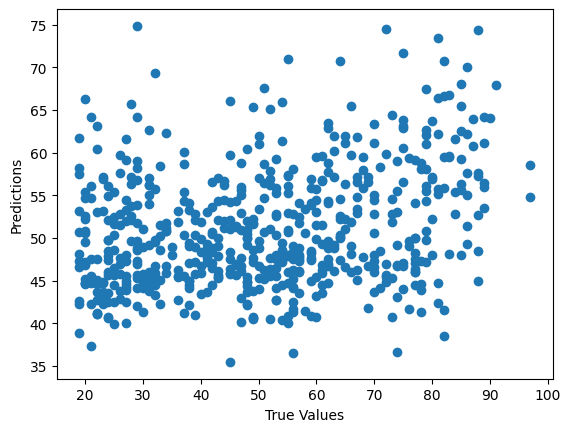

In [88]:
age_regression_and_plot(features[comorbidity<0], age[comorbidity<0])

In [81]:
from umap import UMAP

reducer = UMAP(n_neighbors=15, n_components=2, metric='euclidean')
embedding = reducer.fit_transform(features)

c:\Users\Zhenyu's PC\torch\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


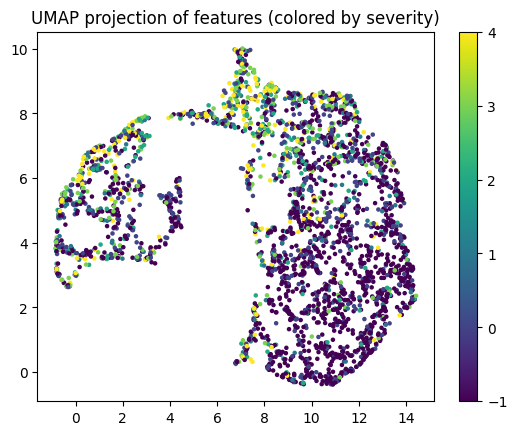

In [82]:
plt.scatter(embedding[:, 0], embedding[:, 1], c=comorbidity, s=5)
plt.colorbar()
plt.title('UMAP projection of features (colored by severity)')
plt.show()

## FFT baseline

In [ ]:
def read_channel_name(filename):
    import h5py
    with h5py.File(filename, 'r') as f:
        ch_name = f['EEG_channels'][:]
    return ch_name

read_channel_name(r"D:\EEG\FHA\Resting\001_a01_01\Meta.hdf5")

In [89]:
from scipy.signal import welch


In [ ]:
x, fs = welch(dataset_eval[0]['EEG_Raw'], fs=256, nperseg=256, axis=-1)

In [91]:
PSD = []
Age = []
comorbidity = []
for i in range(len(dataset_eval)):
    x, fs = welch(dataset_eval[i]['EEG_Raw'], fs=256, nperseg=256, axis=-1)
    PSD.append(fs[:,:50])
    Age.append(dataset_eval[i]['Age'])
    comorbidity.append(dataset_eval[i]['ComorbidityLevelDesc'])
PSD = np.array(PSD)
Age = np.array(Age)
comorbidity = np.array(comorbidity)

In [100]:
PSD.shape

(3022, 1, 50)

In [101]:
abnormality_detection(PSD[:,0], comorbidity>0)

AUC Score: 0.7557730496453902


np.float64(0.7557730496453902)